Using XGboosting.

Reference: 
https://github.com/nikhilpatil44/rossmann-store-sales-prediction/blob/main/rossmann-store-sale.ipynb

https://www.kaggle.com/datasets/pratyushakar/rossmann-store-sales/data

https://www.kaggle.com/competitions/rossmann-store-sales


In [2]:
#Import necessary libraries
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
#load dataset
data_path = 'data/preprocessed_data.csv'
print("Loading data from:", data_path)
preprocessed_data = pd.read_csv(data_path)
print(preprocessed_data)

Loading data from: data/preprocessed_data.csv
        Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
0           1          5  2015-07-31   5263        555     1      1   
1           2          5  2015-07-31   6064        625     1      1   
2           3          5  2015-07-31   8314        821     1      1   
3           4          5  2015-07-31  13995       1498     1      1   
4           5          5  2015-07-31   4822        559     1      1   
...       ...        ...         ...    ...        ...   ...    ...   
844333    682          2  2013-01-01   3375        566     1      0   
844334    733          2  2013-01-01  10765       2377     1      0   
844335    769          2  2013-01-01   5035       1248     1      0   
844336    948          2  2013-01-01   4491       1039     1      0   
844337   1097          2  2013-01-01   5961       1405     1      0   

        StateHoliday  SchoolHoliday  StoreType  Assortment  \
0                  0              1    

In [4]:
# Handle any other object columns if they exist
object_columns = preprocessed_data.select_dtypes(include=['object']).columns.tolist()
if object_columns:
    print(f"  Additional object columns found: {object_columns}")
    preprocessed_data = pd.get_dummies(
        preprocessed_data, 
        columns=object_columns, 
        drop_first=False
        )

  Additional object columns found: ['Date', 'PromoInterval']


In [5]:
#Preprocess the data
#Define features (X) and target (y)
X = preprocessed_data.drop(["Sales", "Date", "PromoInterval"], axis=1, errors='ignore')
y = preprocessed_data["Sales"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=50)

In [6]:
#define model
model = xgb.XGBRegressor(
    n_estimators=5000,
    learning_rate=1,
    max_depth=5,
    random_state=50,
    objective='reg:squarederror',
    device='cuda',
    early_stopping_rounds=50,
    ) 

In [7]:
#train the model
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
    )

[0]	validation_0-rmse:1417.26693
[100]	validation_0-rmse:650.39631
[200]	validation_0-rmse:541.53439
[300]	validation_0-rmse:505.85240
[400]	validation_0-rmse:491.70945
[500]	validation_0-rmse:484.48043
[600]	validation_0-rmse:483.31491
[645]	validation_0-rmse:484.38683


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, random_state=50, ...)

In [18]:
#evaluate the model
#Define RMSPE function (Root Mean Square Percentage Error)
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))
y_pred = model.predict(X_val)
rmspe_score = rmspe(y_val, y_pred)
rmse_score = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse_score:.2f}, RMSPE: {rmspe_score:.4f}")

RMSE: 483.18, RMSPE: 0.0790


In [9]:
#avarage sale
average_sales = preprocessed_data["Sales"].mean()
print(average_sales)

6955.959133664481


In [10]:
#Save the trained model
model.save_model('xgboost_sales_model.json')

Apply to ABC

In [11]:
#3 Feature importance
feature_importance = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False).head(3)
    
print("\n  Top 3 important features:")
for i, row in importance_df.iterrows():
    print(f"  {row['Feature']}: {row['Importance']:.6f}")


  Top 3 important features:
  Customers: 0.051714
  StoreType: 0.035441
  Promo: 0.030640


Recommendations to Increase Sales and Profit.

In [12]:
#Analyze sales by StoreType
storetype_sales = preprocessed_data.groupby('StoreType')['Sales'].mean().sort_values(ascending=False)
print("\nAverage Sales by StoreType:")
print(storetype_sales)


Average Sales by StoreType:
StoreType
1    10233.380141
2     6933.126425
0     6925.697986
3     6822.300064
Name: Sales, dtype: float64


In [13]:
#Average Sales with/without Promo
promo_sales = preprocessed_data.groupby('Promo')['Sales'].mean()
print(promo_sales)

Promo
0    5929.826183
1    8228.739731
Name: Sales, dtype: float64


In [14]:
print(preprocessed_data.columns.tolist())

['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Date_2013-01-01', 'Date_2013-01-02', 'Date_2013-01-03', 'Date_2013-01-04', 'Date_2013-01-05', 'Date_2013-01-06', 'Date_2013-01-07', 'Date_2013-01-08', 'Date_2013-01-09', 'Date_2013-01-10', 'Date_2013-01-11', 'Date_2013-01-12', 'Date_2013-01-13', 'Date_2013-01-14', 'Date_2013-01-15', 'Date_2013-01-16', 'Date_2013-01-17', 'Date_2013-01-18', 'Date_2013-01-19', 'Date_2013-01-20', 'Date_2013-01-21', 'Date_2013-01-22', 'Date_2013-01-23', 'Date_2013-01-24', 'Date_2013-01-25', 'Date_2013-01-26', 'Date_2013-01-27', 'Date_2013-01-28', 'Date_2013-01-29', 'Date_2013-01-30', 'Date_2013-01-31', 'Date_2013-02-01', 'Date_2013-02-02', 'Date_2013-02-03', 'Date_2013-02-04', 'Date_2013-02-05', 'Date_2013-02-06', 'Date_2013-02-07', 'Date_2013-02-08', 'Date_201

In [15]:
#Table of Sales by Day of Week
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])
data['DayOfWeek'] = data['Date'].dt.day_name()
dayofweek_sales = data.groupby('DayOfWeek')['Sales'].mean().sort_values(ascending=False)
print("\nAverage Sales by Day of Week (Table):")
print(dayofweek_sales)


Average Sales by Day of Week (Table):
DayOfWeek
Sunday       8224.723908
Monday       8216.252259
Tuesday      7088.409086
Friday       7073.034133
Thursday     6768.214973
Wednesday    6728.786679
Saturday     5875.084935
Name: Sales, dtype: float64


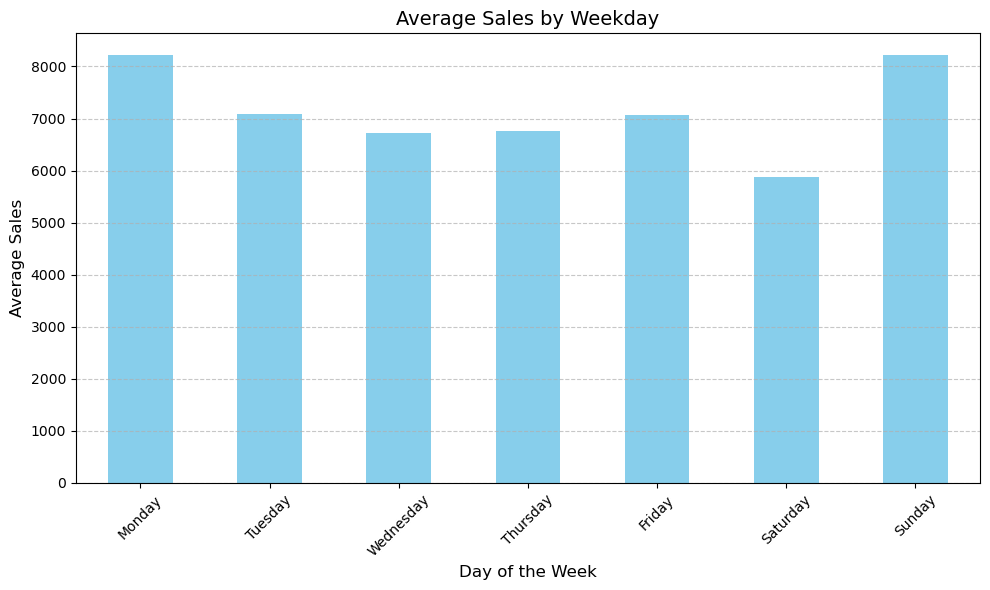

Average Sales by Weekday:
DayOfWeek
Monday       8216.252259
Tuesday      7088.409086
Wednesday    6728.786679
Thursday     6768.214973
Friday       7073.034133
Saturday     5875.084935
Sunday       8224.723908
Name: Sales, dtype: float64


In [16]:
# Plot Sales by Weakday
data['DayOfWeek'] = data['Date'].dt.day_name()
weekday_sales = data.groupby('DayOfWeek')['Sales'].mean()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales = weekday_sales.reindex(weekday_order)

plt.figure(figsize=(10, 6))
weekday_sales.plot(kind='bar', color='skyblue')
plt.title('Average Sales by Weekday', fontsize=14)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Average Sales by Weekday:")
print(weekday_sales)

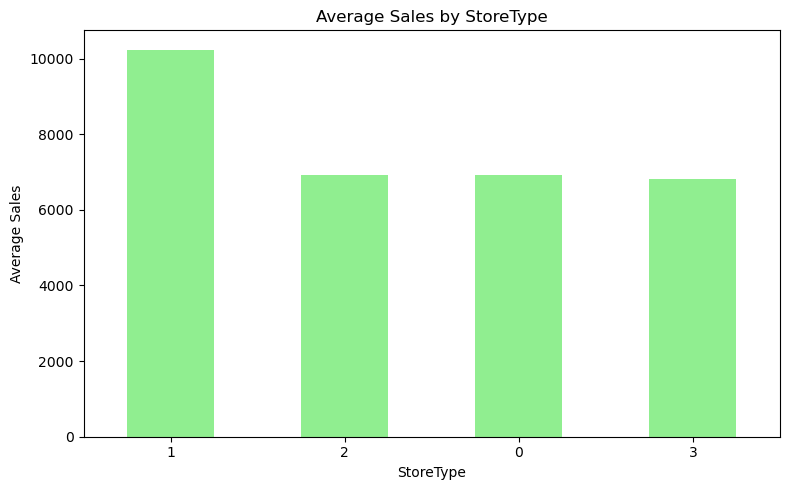

In [17]:
# Plot Sales by StoreType
plt.figure(figsize=(8, 5))
storetype_sales.plot(kind='bar', color='lightgreen')
plt.title('Average Sales by StoreType')
plt.xlabel('StoreType')
plt.ylabel('Average Sales')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

xgb_results = pd.DataFrame({
    'y_val': y_val,
    'y_pred_xgb': y_pred
})
xgb_results.to_csv('prediction/xgb_predictions.csv', index=False)